## Chest pathology detection


### Initialize TensorFlow 2.0 and Mount the google drive to consume data

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.0'

In [2]:
# Initialize the random number generator
import random
from tensorflow.keras import utils
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# In order to use tqdm progress bar library....
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [ ]:
# run this cell to to mount the google drive if you are using google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

Store the train/test and all csv files in google drive instead of storing in the VM for faster access. Also we will not lose train/test directories when the VM is reallocated..

In [ ]:
train_dir_path = '/content/drive/My Drive/Dec2020_processed_data/data/train/'
test_dir_path = '/content/drive/My Drive/Dec2020_processed_data/data/test/'

metadata_dir_path = '/content/drive/My Drive/Dec2020_processed_data/data/metadata/'
vm_train_dir = "/content/train/"
vm_trainx_dir = "/content/trainX/"
vm_valx_dir = "/content/valX"
vm_test_dir = "/content/test/" # Not used for now.

num_classes = 3

In [ ]:
!ls '/content/drive/My Drive/Dec2020_processed_data/data/train'

In [ ]:
!mkdir "/content/train"
!mkdir "/content/trainX"
!mkdir "/content/valX"
!mkdir "/content/test"

### Unzip the Dataset Files (One time execution until the lifetime of the colab container)

In [9]:
from zipfile import ZipFile

# There are 3 train files
with ZipFile(train_dir_path+'xray-images-train.zip', 'r') as z:
  z.extractall(vm_train_dir)

In [10]:
!ls '/content/train' | wc -l

13958


Repeat the same step for test.zip

In [11]:
# Test file
with ZipFile(test_dir_path+'xray-images-test.zip', 'r') as z:
  z.extractall(vm_test_dir)

In [12]:
!ls '/content/test' | wc -l

1579


### Read the Train and Test csv file using pandas

In [13]:
import pandas as pd

lungxray_train_df = pd.read_csv(metadata_dir_path + 'train_split.txt',delimiter=' ', names=['patient_id', 'xray_img_name', 'target_class', 'img_source'])
lungxray_train_df.shape

(13958, 4)

In [14]:
lungxray_train_df.head()

,patient_id,xray_img_name,target_class,img_source
0,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia,cohen
1,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia,cohen
2,3,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia,cohen
3,7,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia,cohen
4,7,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia,cohen


In [15]:
lungxray_train_df.nunique()['xray_img_name']

13958

30 images are either duplicate or augumented with same name. Examine these images by plotting (Need to do more EDA)

In [16]:
lungxray_test_df = pd.read_csv(metadata_dir_path + 'test_split.txt',delimiter=' ', names=['patient_id', 'xray_img_name', 'target_class', 'img_source'])
lungxray_test_df.shape

(1579, 4)

In [17]:
lungxray_test_df.head()

,patient_id,xray_img_name,target_class,img_source
0,8,SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9...,pneumonia,cohen
1,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
2,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
3,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen
4,31,streptococcus-pneumoniae-pneumonia-temporal-ev...,pneumonia,cohen


### Split the train data in the labels.csv into train and validation dataframes. (Using Stratify)

This is prep work for to use tensor flow 2.0 API's. Tensor flow uses this dataframe to train the model in batches

In [32]:
# Train / Validation split on the dog_labels_df
# Split train data into training and validation.
from sklearn.model_selection import train_test_split

trn_df, val_df = train_test_split(lungxray_train_df, test_size=0.2, random_state=50, 
                                  stratify=lungxray_train_df['target_class'])
#trn_df['xray_img_name'] = trn_df['xray_img_name'] + ".jpg"
#val_df['xray_img_name'] = val_df['xray_img_name'] + ".jpg"

print(trn_df.shape)
print(val_df.shape)

(11166, 4)
(2792, 4)


In [33]:
trn_df.shape
val_df.shape

(2792, 4)

### Block to split train into trainX and valX images to facilitate flow_from_dataframe calls

This will be done based on trn_df and val_df dataframes

In [25]:
import os

def create_dir_in_colab_runtime(path):
  # define the name of the directory to be created
  # define the access rights
  access_rights = 0o755

  try:
      os.mkdir(path, access_rights)
  except OSError:
      print ("Creation of the directory %s failed" % path)
  else:
      print ("Successfully created the directory %s" % path)
  return

In [34]:
# importing shutil module  
import shutil
import os
import sys

# Source path  
src_dir = '/content/train/'  
# Destination paths  
new_train_dir = '/content/trainX/'
new_val_dir = '/content/valX/'

#create_dir_in_colab_runtime(new_train_dir)
#create_dir_in_colab_runtime(new_val_dir)

# Before copying check the number of files in TRAIN directory
src_path, src_dirs, src_files = next(os.walk(src_dir))
src_file_count = len(src_files)
print("train file counts :", src_file_count)

# Move the data from train into trainX and valX 
# Keep the original train as is to maintain the data integrity for future experiments

with tqdm(total=len(trn_df['xray_img_name'].values), file=sys.stdout) as pbar:
  for s in trn_df['xray_img_name'].values:
    pbar.update(1)
    new_trn_path = shutil.copy(src_dir + s, new_train_dir)
pbar.close()

with tqdm(total=len(val_df['xray_img_name'].values), file=sys.stdout) as pbar:
  for t in val_df['xray_img_name'].values:
    pbar.update(1)
    new_val_path = shutil.copy(src_dir + t, new_val_dir)
pbar.close()

trn_path, trn_dirs, trn_files = next(os.walk(new_train_dir))
trn_file_count = len(trn_files)

val_path, val_dirs, val_files = next(os.walk(new_val_dir))
val_file_count = len(val_files)

print("TrainX file count :", trn_file_count)
print("valX file count :", val_file_count)

train file counts : 13958



TrainX file count : 11166
valX file count : 2792


In [35]:
!ls '/content/valX' | wc -l

2792


In [37]:
!ls -l '/content/trainX/0a13f9596e03a9f87c96aaff6e057048.jpg'

ls: cannot access '/content/trainX/0a13f9596e03a9f87c96aaff6e057048.jpg': No such file or directory


### Print the count of each category of chest pathology given in the dataset



In [18]:
lungxray_train_df.groupby('target_class').count()

,patient_id,xray_img_name,img_source
target_class,,,
COVID-19,517,517,517
normal,7966,7966,7966
pneumonia,5475,5475,5475


### Common functions required for all models
* Plot accuracy loss
* Round_up

In [19]:
import math

def plot_train_val_accuracy(history,title):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
  plt.show()


def plot_train_accuracy(history,title):
  plt.title(title)
  plt.plot(history.history['accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train_accuracy'], loc='best')
  plt.show()


def plot_train_val_loss(history,title):
  plt.title(title)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'validation_loss'], loc='best')
  plt.show()

def plot_train_loss(history,title):
  plt.title(title)
  plt.plot(history.history['loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss'], loc='best')
  plt.show()

def round_up(n, decimals=0): 
  multiplier = 10 ** decimals 
  return math.ceil(n * multiplier) / multiplier

### Transfer Learning - Using VGG16
* Use VGG16 weights ( downloaded )
* Trained on ImageNet
* No pixel normalization


*VGG16 uses input image size of 224. Provide the inputs in this resolution* 

In [34]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

input_resolution = 448


# Instantiate the model with the pre-trained weights (no top)
#base_model= VGG16(weights=(src_dir_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
#                  include_top=False, pooling='avg', input_shape=(224,224,3))


base_model= VGG16(weights='imagenet',
                  include_top=False, 
                  pooling='avg', 
                  input_shape=(input_resolution,input_resolution,3))

# Take a look at the model summary
base_model.summary()

layer_count=0
# mark loaded layers as not trainable
for layer in base_model.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_model.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 224, 224, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 224, 224, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 224, 224, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 112, 128)     0     

In [35]:
img_height = input_resolution
img_width = input_resolution
batch_size = 32
epochs = 10

Run this block to execute both training & validation

Found 11166 validated image filenames belonging to 3 classes.
Found 2792 validated image filenames belonging to 3 classes.
349.0 88.0
Epoch 1/10
349/349 [==============================] - 332s 925ms/step - loss: 0.9451 - accuracy: 0.7173 - val_loss: 0.4113 - val_accuracy: 0.8571
Epoch 2/10
349/349 [==============================] - 309s 885ms/step - loss: 0.5119 - accuracy: 0.8201 - val_loss: 0.3656 - val_accuracy: 0.8653
Epoch 3/10
349/349 [==============================] - 287s 823ms/step - loss: 0.4299 - accuracy: 0.8378 - val_loss: 0.3649 - val_accuracy: 0.8643
Epoch 4/10
349/349 [==============================] - 286s 819ms/step - loss: 0.4203 - accuracy: 0.8408 - val_loss: 0.3531 - val_accuracy: 0.8650
Epoch 5/10
349/349 [==============================] - 288s 824ms/step - loss: 0.4192 - accuracy: 0.8358 - val_loss: 0.3464 - val_accuracy: 0.8707
Epoch 6/10
349/349 [==============================] - 286s 820ms/step - loss: 0.4206 - accuracy: 0.8447 - val_loss: 0.3459 - val_accurac

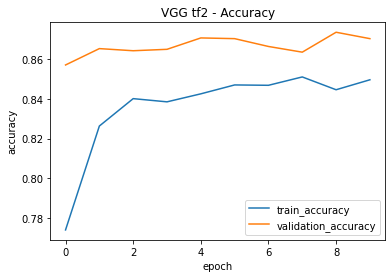

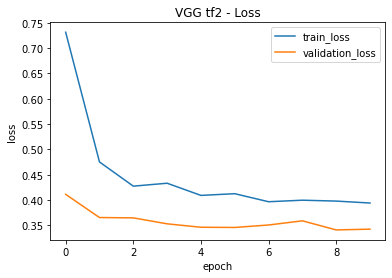

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

# Train data - prepare data augmentation configuration 
#train_datagen = ImageDataGenerator()

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=trn_df, 
    directory=vm_trainx_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Test data - Get it ready - No augumentation
#valid_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

#valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=val_df, 
    directory=vm_valx_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)
STEP_SIZE_VALID=round_up(valid_generator.n/valid_generator.batch_size)

print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=valid_generator,
    validation_steps=STEP_SIZE_VALID,
    epochs=epochs)

plot_train_val_accuracy(history, "VGG tf2 - Accuracy")
plot_train_val_loss(history, "VGG tf2 - Loss")

Run the full model without validation (to make the model more robust )

Found 13958 validated image filenames belonging to 3 classes.
437.0
Epoch 1/10
437/437 [==============================] - 716s 2s/step - loss: 0.9412 - accuracy: 0.7182
Epoch 2/10
437/437 [==============================] - 714s 2s/step - loss: 0.4594 - accuracy: 0.8302
Epoch 3/10
437/437 [==============================] - 713s 2s/step - loss: 0.4050 - accuracy: 0.8484
Epoch 4/10
437/437 [==============================] - 705s 2s/step - loss: 0.4150 - accuracy: 0.8408
Epoch 5/10
437/437 [==============================] - 705s 2s/step - loss: 0.4050 - accuracy: 0.8464
Epoch 6/10
437/437 [==============================] - 705s 2s/step - loss: 0.3789 - accuracy: 0.8540
Epoch 7/10
437/437 [==============================] - 704s 2s/step - loss: 0.3793 - accuracy: 0.8558
Epoch 8/10
437/437 [==============================] - 700s 2s/step - loss: 0.3864 - accuracy: 0.8492
Epoch 9/10
437/437 [==============================] - 699s 2s/step - loss: 0.3760 - accuracy: 0.8554
Epoch 10/10
437/437 [==

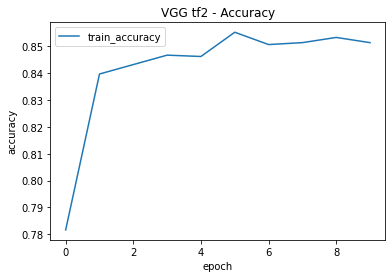

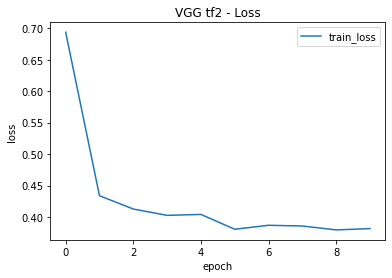

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(rescale=1./255, 
#                                   preprocessing_function = preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   shear_range=0.2,
                                   zoom_range=0.2)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=vm_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "VGG tf2 - Accuracy")
plot_train_loss(history, "VGG tf2 - Loss")

Print the Test loss, accuracy and confusion matrix

In [37]:
# Print the loss and accuracy
from sklearn import metrics
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=vm_test_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 1579 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
50/50 [==============================] - 32s 625ms/step - loss: 0.3377 - accuracy: 0.8733
Accuracy: 0.873
Loss: 0.338
50/50 [==============================] - 31s 616ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 45  19  36]
 [  0 852  33]
 [  0 112 482]]
              precision    recall  f1-score   support

           0       1.00      0.45      0.62       100
           1       0.87      0.96      0.91       885
           2       0.87      0.81      0.84       594

    accuracy                           0.87      1579
   macro avg       0.91      0.74      0.79      1579
weighted avg       0.88      0.87      0.87      1579



In [ ]:
y_predict.shape

### Use Resnet50

* Import Resnet50 from tensorflow.keras.applications
* Implement the dense layer as per the dogbreed classification usecase with 120 classes output
* Compile the new model


In [20]:
input_resolution = 448
img_height = input_resolution
img_width = input_resolution
batch_size = 32
epochs = 10
num_classes = 3

In [21]:
# Use tf.keras.applications to refer the model directly....(DONNOT DOWNLOAD !)
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

base_resnet50 = ResNet50(include_top=False, input_shape=(img_height, img_width, 3), pooling='avg', weights='imagenet')

# mark loaded layers as not trainable
#base_resnet50.trainable = False

print(base_resnet50.summary())

layer_count=0
# mark loaded layers as not trainable
for layer in base_resnet50.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_resnet50.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

x = layers.Dense(2048, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_resnet50.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])


94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 454, 454, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 224, 224, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 224, 224, 64) 256         conv1_conv[0][0]                 
__________________________

* Read images from the VM and perform normalization
* Stream the images from train directory for training
* Evaluate the validation accuracy..

Found 13958 validated image filenames belonging to 3 classes.
437.0
Epoch 1/10
437/437 [==============================] - 785s 2s/step - loss: 0.8455 - accuracy: 0.7750
Epoch 2/10
437/437 [==============================] - 745s 2s/step - loss: 0.3860 - accuracy: 0.8593
Epoch 3/10
437/437 [==============================] - 695s 2s/step - loss: 0.3558 - accuracy: 0.8703
Epoch 4/10
437/437 [==============================] - 696s 2s/step - loss: 0.3309 - accuracy: 0.8727
Epoch 5/10
437/437 [==============================] - 702s 2s/step - loss: 0.3194 - accuracy: 0.8833
Epoch 6/10
437/437 [==============================] - 704s 2s/step - loss: 0.3247 - accuracy: 0.8762
Epoch 7/10
437/437 [==============================] - 701s 2s/step - loss: 0.3212 - accuracy: 0.8796
Epoch 8/10
437/437 [==============================] - 709s 2s/step - loss: 0.3196 - accuracy: 0.8801
Epoch 9/10
437/437 [==============================] - 698s 2s/step - loss: 0.3083 - accuracy: 0.8818
Epoch 10/10
437/437 [==

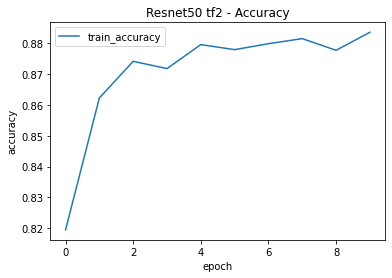

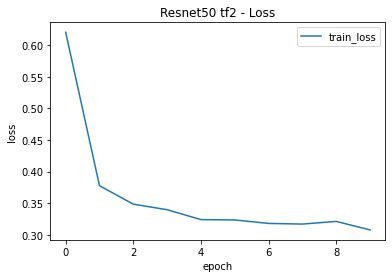

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
#                                   shear_range=0.2,
#                                   zoom_range=0.2)

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=vm_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Resnet50 tf2 - Accuracy")
plot_train_loss(history, "Resnet50 tf2 - Loss")

In [23]:
# Print the loss and accuracy
from sklearn import metrics
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=vm_test_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 1579 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
50/50 [==============================] - 36s 693ms/step - loss: 0.2563 - accuracy: 0.9075
Accuracy: 0.908
Loss: 0.256
50/50 [==============================] - 31s 584ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 70  15  15]
 [  0 841  44]
 [  0  72 522]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82       100
           1       0.91      0.95      0.93       885
           2       0.90      0.88      0.89       594

    accuracy                           0.91      1579
   macro avg       0.93      0.84      0.88      1579
weighted avg       0.91      0.91      0.91      1579



### InceptionV3 net

In [20]:
input_resolution = 448
img_height = input_resolution
img_width = input_resolution
batch_size = 32
epochs = 10
num_classes = 3

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

base_inceptionv3 = InceptionV3(include_top=False, input_shape=(img_height, img_width, 3), pooling='avg', weights='imagenet')

# mark loaded layers as not trainable
#base_resnet50.trainable = False

print(base_inceptionv3.summary())

layer_count=0
# mark loaded layers as not trainable
for layer in base_inceptionv3.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_inceptionv3.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

x = layers.Dense(2048, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_inceptionv3.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

87916544/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 223, 223, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 223, 223, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 223, 223, 32) 0           batch_normalization[0][0]        
______________________

Found 13958 validated image filenames belonging to 3 classes.
437.0
Epoch 1/10
437/437 [==============================] - 736s 2s/step - loss: 0.9906 - accuracy: 0.7268
Epoch 2/10
437/437 [==============================] - 702s 2s/step - loss: 0.4654 - accuracy: 0.8234
Epoch 3/10
437/437 [==============================] - 671s 2s/step - loss: 0.4163 - accuracy: 0.8414
Epoch 4/10
437/437 [==============================] - 674s 2s/step - loss: 0.4084 - accuracy: 0.8421
Epoch 5/10
437/437 [==============================] - 682s 2s/step - loss: 0.3823 - accuracy: 0.8583
Epoch 6/10
437/437 [==============================] - 676s 2s/step - loss: 0.3841 - accuracy: 0.8521
Epoch 7/10
437/437 [==============================] - 674s 2s/step - loss: 0.3902 - accuracy: 0.8508
Epoch 8/10
437/437 [==============================] - 671s 2s/step - loss: 0.3844 - accuracy: 0.8543
Epoch 9/10
437/437 [==============================] - 668s 2s/step - loss: 0.3964 - accuracy: 0.8462
Epoch 10/10
437/437 [==

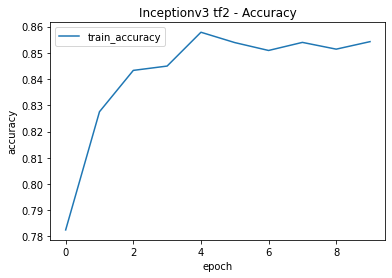

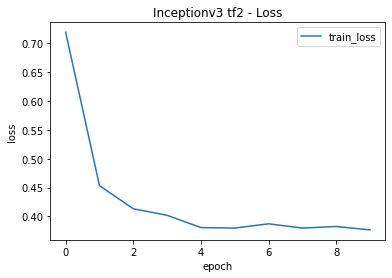

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
#                                   shear_range=0.2,
#                                   zoom_range=0.2)

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

'''
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
'''                                  

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')


# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=vm_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Inceptionv3 tf2 - Accuracy")
plot_train_loss(history, "Inceptionv3 tf2 - Loss")

In [23]:
# Print the loss and accuracy
from sklearn import metrics
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=vm_test_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 1579 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
50/50 [==============================] - 32s 611ms/step - loss: 0.3650 - accuracy: 0.8765
Accuracy: 0.877
Loss: 0.365
50/50 [==============================] - 25s 475ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 35  19  46]
 [  0 838  47]
 [  0  83 511]]
              precision    recall  f1-score   support

           0       1.00      0.35      0.52       100
           1       0.89      0.95      0.92       885
           2       0.85      0.86      0.85       594

    accuracy                           0.88      1579
   macro avg       0.91      0.72      0.76      1579
weighted avg       0.88      0.88      0.87      1579



### MobileNetV2 ( Recommended for Classification, Detection and Segmentation of images ) - Designed for Edge devices 

In [24]:
img_resolution = 448
img_height = img_resolution
img_width = img_resolution
batch_size = 32 # default batch size 
#batch_size = 96 # Also try with batch size 96 as per documentation
epochs = 10
num_classes = 3

In [25]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Flatten

base_mobilenetv2 = MobileNetV2(include_top=False, input_shape=(img_height, img_width, 3), pooling='avg', weights='imagenet')

# mark loaded layers as not trainable
#base_resnet50.trainable = False

print(base_mobilenetv2.summary())

layer_count=0
# mark loaded layers as not trainable
for layer in base_mobilenetv2.layers: 
  layer_count = 1+layer_count
  layer.trainable = False
  
#if layer_count > 17:
#  layer.trainable = True
#else:
#  layer.trainable = False

print("layer count : ", layer_count)
# add new classifier layers
x = base_mobilenetv2.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

x = layers.Dense(1280, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(1024, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)

#x = layers.Dense(256, activation='relu')(x)
#x = layers.BatchNormalization()(x) #Added new
#x = layers.Dropout(0.6)(x)
x = layers.Dense(num_classes, activation='softmax')(x)

'''
x = base_model.output
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x) #Added new
x = layers.Dropout(0.6)(x)
x = layers.Dense(120, activation='softmax')(x)
'''

tf2_model = models.Model(inputs=base_mobilenetv2.input, outputs=x)
print(tf2_model.summary())

base_learning_rate = 0.001

rms = tf.keras.optimizers.RMSprop(lr=base_learning_rate)
adam = tf.keras.optimizers.Adam(lr=base_learning_rate)
tf2_model.compile(optimizer = adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 224, 224, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 224, 224, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 224, 224, 32) 0           bn_Conv1[0][0]                   
________________

Found 13958 validated image filenames belonging to 3 classes.
437.0
Epoch 1/10
437/437 [==============================] - 656s 1s/step - loss: 0.9407 - accuracy: 0.7454
Epoch 2/10
437/437 [==============================] - 646s 1s/step - loss: 0.4422 - accuracy: 0.8369
Epoch 3/10
437/437 [==============================] - 646s 1s/step - loss: 0.3991 - accuracy: 0.8458
Epoch 4/10
437/437 [==============================] - 645s 1s/step - loss: 0.3656 - accuracy: 0.8598
Epoch 5/10
437/437 [==============================] - 644s 1s/step - loss: 0.3686 - accuracy: 0.8596
Epoch 6/10
437/437 [==============================] - 645s 1s/step - loss: 0.3715 - accuracy: 0.8644
Epoch 7/10
437/437 [==============================] - 644s 1s/step - loss: 0.3639 - accuracy: 0.8575
Epoch 8/10
437/437 [==============================] - 644s 1s/step - loss: 0.3544 - accuracy: 0.8572
Epoch 9/10
437/437 [==============================] - 645s 1s/step - loss: 0.3604 - accuracy: 0.8627
Epoch 10/10
437/437 [==

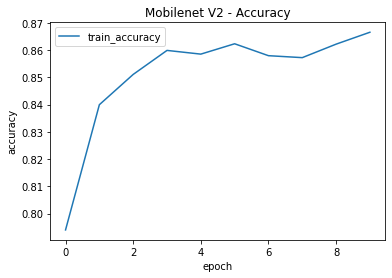

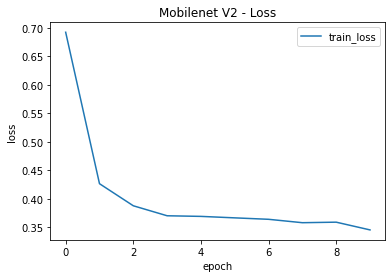

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
#                                   shear_range=0.2,
#                                   zoom_range=0.2)

#train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)



train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

# Train data - Get it ready with augumentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=lungxray_train_df, 
    directory=vm_train_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle=True)

# Start training the model...
STEP_SIZE_TRAIN=round_up(train_generator.n/train_generator.batch_size)

print(STEP_SIZE_TRAIN)

history = tf2_model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs)

plot_train_accuracy(history, "Mobilenet V2 - Accuracy")
plot_train_loss(history, "Mobilenet V2 - Loss")

In [27]:
# Print the loss and accuracy
from sklearn import metrics
import numpy as np
# Import label encoder 
from sklearn import preprocessing 

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=lungxray_test_df, 
    directory=vm_test_dir, 
    x_col="xray_img_name", 
    y_col="target_class",
    class_mode="categorical", 
    target_size=(img_height,img_width), 
    batch_size=batch_size,
    shuffle = False)

print("Test Gen classes :",test_generator.class_indices)

STEP_SIZE_TEST=round_up(test_generator.n/test_generator.batch_size)

loss, accuracy = tf2_model.evaluate_generator(test_generator, 
                                              steps = STEP_SIZE_TEST,
                                              verbose = 1)

print('Accuracy: %.3f'  % accuracy)
print('Loss: %.3f' % loss)

y_predict = tf2_model.predict_generator(test_generator,
                                        steps = STEP_SIZE_TEST,
                                        verbose = 1)

y_predict = np.argmax(y_predict, axis=1)

# First Label encode strings into integers. 
label_encoder = preprocessing.LabelEncoder() 
y_actual = label_encoder.fit_transform(lungxray_test_df['target_class'])

print("LE classes :",label_encoder.classes_)

cm = metrics.confusion_matrix(y_actual,y_predict)
print(cm)
print(metrics.classification_report(y_actual, y_predict))

Found 1579 validated image filenames belonging to 3 classes.
Test Gen classes : {'COVID-19': 0, 'normal': 1, 'pneumonia': 2}
50/50 [==============================] - 24s 451ms/step - loss: 0.3817 - accuracy: 0.8708
Accuracy: 0.871
Loss: 0.382
50/50 [==============================] - 23s 446ms/step
LE classes : ['COVID-19' 'normal' 'pneumonia']
[[ 39  14  47]
 [  0 807  78]
 [  0  65 529]]
              precision    recall  f1-score   support

           0       1.00      0.39      0.56       100
           1       0.91      0.91      0.91       885
           2       0.81      0.89      0.85       594

    accuracy                           0.87      1579
   macro avg       0.91      0.73      0.77      1579
weighted avg       0.88      0.87      0.87      1579

